In [ ]:
# The Final Visualization / Data Exploration NB : Investigates background vs signal, track separation, etc #

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
import os
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [7]:
os.chdir('../TrackML/train_1/train_1/')

In [8]:
file = 'event000002461-truth.csv'
truths = pd.read_csv(file)
truth_short = pd.DataFrame(truths, columns=['hit_id', 'particle_id'])
truth_short.describe()

,hit_id,particle_id
count,118316.000000,1.183160e+05
mean,59158.500000,3.931009e+17
std,34155.031562,2.970996e+17
min,1.000000,0.000000e+00
25%,29579.750000,1.261269e+17
50%,59158.500000,3.647938e+17
75%,88737.250000,6.440191e+17
max,118316.000000,9.592740e+17


In [ ]:
# We group the hits by the track they belong to, then create a DataFrame that counts how many hits were included
# for a given particle_id.  The count function gives this number for any specified ID.

In [9]:
hits_per_track = truth_short.groupby('particle_id')
dfcount = hits_per_track.count()

def count(x):
    return int(dfcount.iloc[x])

hits_per_track.count().describe()

,hit_id
count,10170.000000
mean,11.633825
std,178.149411
min,1.000000
25%,8.000000
50%,11.000000
75%,13.000000
max,17971.000000


In [ ]:
# While most particle_ids have between 8 and 13 hits, one particle_id (0) has 10,170 hits.  This is the background.

# The background is noise, meaning it doesn't contribute to any of the particle tracks in our signal.  Our model
# should then learn to reject background hits, which it will do by assigning them to particle_id 0. This id will
# function as a garbage dump for hits that do not correspond to any challenge-defined track.

# Let's see how many nuisance hits we have to deal with:

In [10]:
background_percentage = (count(0) / int(dfcount.sum()))
print("Background hits make up " + "%.3f" % (100 * background_percentage) + '%' + " of all hits")

Background hits make up 15.189% of all hits


In [11]:
# Perhaps a nicer looking syntax (useful for later when complicated): #

print('{0} {percent:1.3%} {1} {file}'.format('Background hits make up', 'of all hits in', 
                                             file=file.replace('.csv', ''), percent=background_percentage))

Background hits make up 15.189% of all hits in event000002461-truth


In [130]:
# Since this is a sizeable portion of events, it would be helpful if we could identify a pattern that made the
# background easy to reject.  We look for one in the spatial distribution of the bckd hits(particle_id == 0) via
# their position coordinates in the 'hits' file:

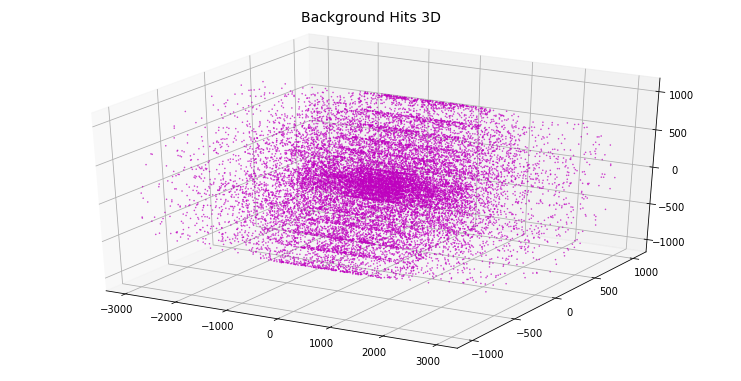

In [12]:
file2 = file.replace("truth", "hits")
hits = pd.read_csv(file2, usecols= ['hit_id', 'x', 'y', 'z'])

Bkgd_hits = list(truth_short.query('particle_id == \
                    0').hit_id)

Bkgd_hits_xyz = hits[hits.hit_id.isin(Bkgd_hits)]

x_val = np.array(list(Bkgd_hits_xyz['x']))
y_val = np.array(list(Bkgd_hits_xyz['y']))
z_val = np.array(list(Bkgd_hits_xyz['z']))

fig = plt.figure(figsize=(10, 5))
ax = Axes3D(fig)
fig.suptitle('Background Hits 3D', color='black',fontsize=14, y=1)
    
ax.scatter(z_val, x_val, y_val, s=1.2, color='m', marker='.', alpha=.75)
plt.show()

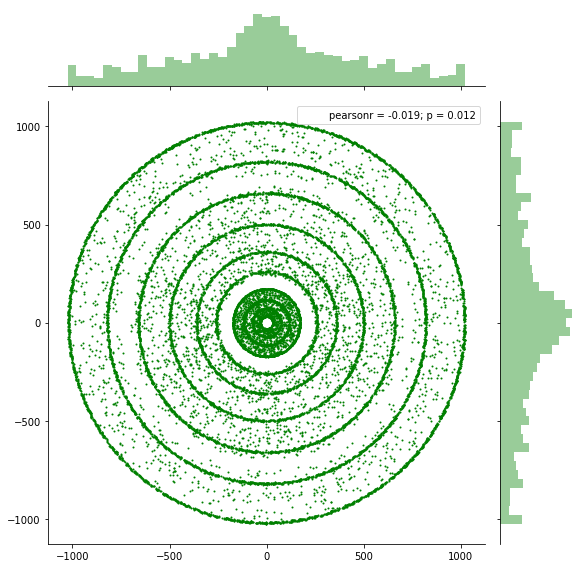

In [13]:
# To-do: Combine these plots side by side as the result of a user-defined function call. #

sns.jointplot(x_val, y_val, size=8, s=1, alpha=1, color='green', kind='scatter')
plt.show()

In [ ]:
### Let's examine the spatial relationships between all track and background hits; for instance, can we identify ###
### individual tracks by eye, or are they hopelessly engulfed in a sea of unrelated hits?  Once we know this,    ###
### we can preliminarily determine whether or not specific clustering algorithms will be useful to us.           ###

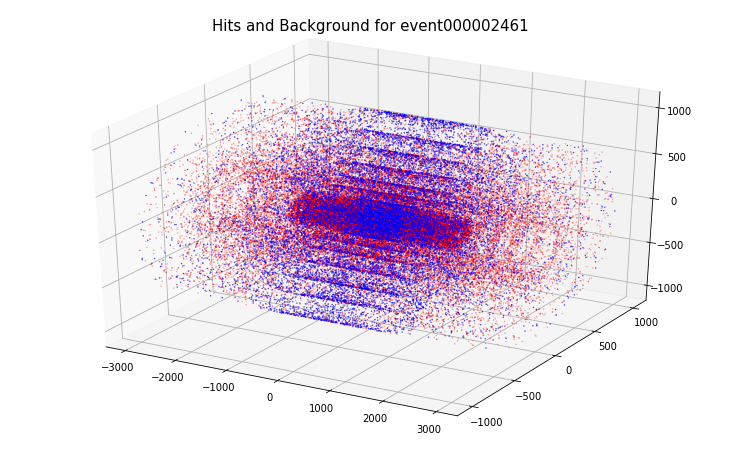

In [14]:
signal = hits[~hits.hit_id.isin(Bkgd_hits)]

x_vals = np.array(list(signal['x']))
y_vals = np.array(list(signal['y']))
z_vals = np.array(list(signal['z']))

fig = plt.figure(figsize=(10, 6))
ax = Axes3D(fig)
plt.suptitle('Hits and Background for event000002461', fontsize='15')

ax.scatter(z_vals, x_vals, y_vals, s=0.5, color='r', marker='.', alpha=0.5)
ax.scatter(z_val, x_val, y_val, s=0.5, color='b', marker='.', alpha=1)

plt.show()

In [ ]:
# Hard to tell what's going on; best to zoom in and take a closer look at specific tracks w.r.t. the bkgd. #

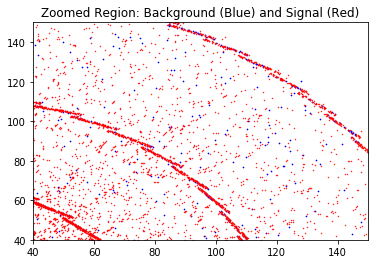

In [16]:
fig, ax = plt.subplots()

ax.scatter(x_val, y_val, c='blue', s=0.5, alpha=1, marker='x')
ax.scatter(x_vals, y_vals, c='red', s=0.2, alpha=1)

plt.xlim(40, 150)
plt.ylim(40, 150)
plt.title('Zoomed Region: Background (Blue) and Signal (Red)')

plt.show()

In [ ]:
# Identifying and highlighting the tracks in the zoomed in region... #

In [18]:
# Recall: signal = hits[~hits.hit_id.isin(Bkgd_hits)]  #
# truth_short = truth with only hit_id, particle_id    #

zoomed_signal = signal.query('40 < x < 150 and 40 < y < 150')               # hit_id and x, y, z for hits in zoomed
signal_hits_in_zoom = list(zoomed_signal.hit_id)                            # list of hit_ids only for hits in zoomed
zoomed_truth = truths[truths.hit_id.isin(signal_hits_in_zoom)]    # hit_id, p_id for hits in zoomed

ids_in_zoom = list(zoomed_truth.groupby('particle_id').count().query('hit_id > 3').index)  # p_ids with 4+ hits in zoom
zoomed_truth_multi = zoomed_truth[zoomed_truth.particle_id.isin(ids_in_zoom)] # hit_id, P_id, tx, ty, tz for 4+ in zoom

test_id = 490893733772918784
zoomed_truth_multi[zoomed_truth_multi['particle_id'] == test_id]

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
885,886,490893733772918784,144.6700,61.6239,-1502.0,0.452621,0.147134,-4.55407,0.000003
2585,2586,490893733772918784,124.7930,54.9051,-1302.0,0.451517,0.157651,-4.55456,0.000003
4591,4592,490893733772918784,105.0560,47.7176,-1102.0,0.447989,0.168697,-4.55499,0.000003
6906,6907,490893733772918784,91.3599,42.3795,-962.0,0.444408,0.177365,-4.55566,0.000004


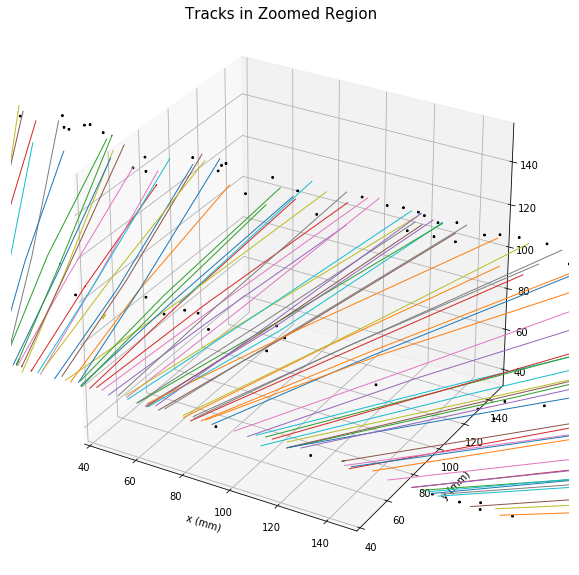

In [19]:
data = zoomed_truth_multi.drop(['tpx', 'tpy', 'tpz', 'weight'], axis=1)
tracks = data.particle_id.unique()

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
for track in tracks:
    t = data[data.particle_id == track]
    ax.plot3D(t.tz, t.tx, t.ty, lw=1)

x_values = np.array(list(Bkgd_hits_xyz.query('40 < x < 150 and 40 < y < 150')['x']))
y_values = np.array(list(Bkgd_hits_xyz.query('40 < x < 150 and 40 < y < 150')['y']))
z_values = np.array(list(Bkgd_hits_xyz.query('40 < x < 150 and 40 < y < 150')['z']))
ax.scatter(z_values, x_values, y_values, c='black', s=4, alpha=1, marker='x')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.xlim(40, 150)
plt.ylim(40, 150)
plt.suptitle('Tracks in Zoomed Region', y=0.90, fontsize=15)

plt.show()

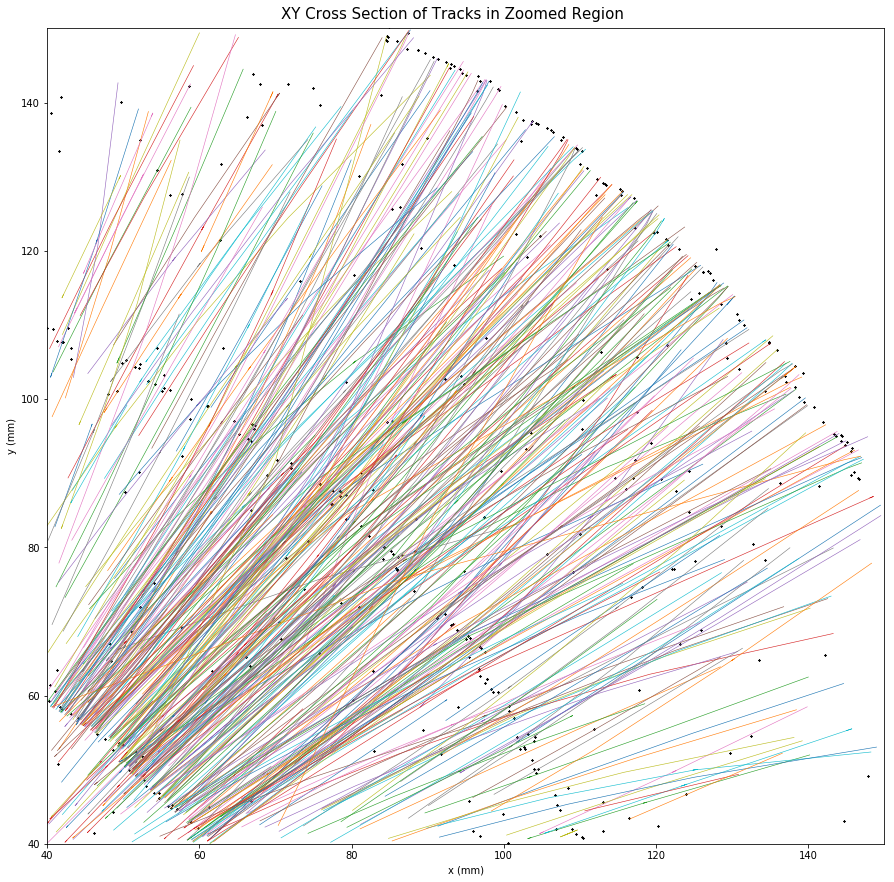

In [20]:
data = zoomed_truth_multi.drop(['tpx', 'tpy', 'tpz', 'weight'], axis=1)
tracks = data.particle_id.unique()

plt.figure(figsize=(15,15))
ax = plt.axes()
for track in tracks:
    t = data[data.particle_id == track]
    ax.plot(t.tx, t.ty, lw=0.6)
    
ax.scatter(x_val, y_val, c='black', s=2, alpha=1, marker='x')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.xlim(40, 150)
plt.ylim(40, 150)
plt.suptitle('XY Cross Section of Tracks in Zoomed Region', y=0.90, fontsize=15)

plt.show()

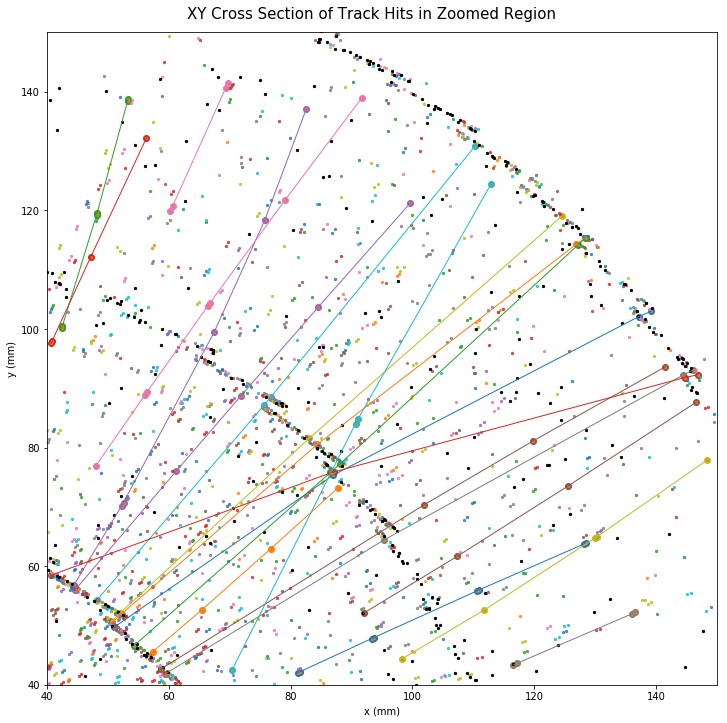

In [21]:
data = zoomed_truth_multi.drop(['tpx', 'tpy', 'tpz', 'weight'], axis=1)
tracks = data.particle_id.unique()

plt.figure(figsize=(12,12))
ax = plt.axes()

for track in tracks[1::20]:
    t = data[data.particle_id == track]
    ax.plot(t.tx, t.ty, lw=1)
    ax.scatter(t.tx, t.ty)
for track in tracks:
    t = data[data.particle_id == track]
    ax.scatter(t.tx, t.ty, s=5, alpha=0.8)

    
ax.scatter(x_val, y_val, c='black', s=5, alpha=1, marker='o')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.xlim(40, 150)
plt.ylim(40, 150)
plt.suptitle('XY Cross Section of Track Hits in Zoomed Region', y=0.91, fontsize=15)

plt.show()

In [61]:
# Let's apply a transform to the data:

test_trans = truths[truths['particle_id'] == test_id].drop(['tpx', 'tpy', 'tpz', 'weight'], axis=1)

xva = []
yva = []
for hit in test_trans.hit_id.unique():
    t = test_trans[test_trans.hit_id == hit]
    R = (t.tx ** 2 + t.ty ** 2 + t.tz ** 2)**(0.5)
    t.tx = t.tx / R
    t.ty = t.ty / R
    xva.append(t.tx.values)
    yva.append(t.ty.values)

In [62]:
XX = []
YY = []

for i in range(len(xva)):
    XX.append(xva[i][0])
for i in range(len(yva)):
    YY.append(xva[i][0])

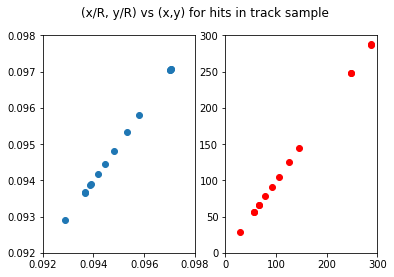

In [91]:
f, (ax1, ax2) = plt.subplots(1, 2)

ax1.scatter(XX, YY)
ax1.set_xlim(0.092, 0.098)
ax1.set_ylim(0.092, 0.098)

xtruth = truths[truths.particle_id == test_id]['tx'].values
ytruth = truths[truths.particle_id == test_id]['tx'].values

ax2.scatter(xtruth, ytruth, color='red', alpha=1, marker='o')
plt.xlim(0, 300)
plt.ylim(0, 300)

plt.suptitle('(x/R, y/R) vs (x,y) for hits in track sample')
plt.show()

In [92]:
# Naively, hits seem more spread out in the untransformed case.